In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import io, datasets, transforms
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
#enable cuda
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device('cuda')
    loader_kwargs = {'num_workers': 1, 'pin_memory': True}
else:
    device = torch.device('cpu')
    loader_kwargs = {}
    
print(device)

cuda


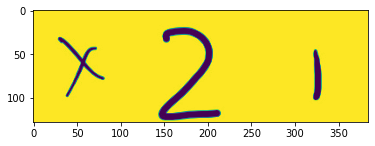

In [3]:
class ExpressionDataset(Dataset):
    """Binomial expression dataset"""
    
    def __init__(self, csv_file, root_dir):
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, self.labels.iloc[idx,0])
        img = io.read_image(img_name).float()
        exprtype, ans = self.labels.iloc[idx,1:]
        exprtype_int = 0
        if exprtype == "infix":
            exprtype_int = 1
        elif exprtype == "postfix":
            exprtype_int = 2
        return [img, exprtype_int, ans+9]

dataset = ExpressionDataset(csv_file='../input/soml-hackathon/SoML/SoML-50/annotations.csv', root_dir='../input/soml-hackathon/SoML/SoML-50/data')
plt.imshow(dataset[10][0].squeeze())

In [4]:
train_set, test_set, validation_set = torch.utils.data.random_split(dataset, [40000,5000,5000])

train_loader = DataLoader(train_set, batch_size=50, shuffle=True)
test_loader = DataLoader(test_set, batch_size=50, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=50, shuffle=True)

In [16]:
class ExpressionTypeNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 8)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 4)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1900, 100)
        self.fc2 = nn.Linear(100, 3)

#        self.input_layer = torch.nn.Linear(128*384, 192)
        #self.hl1 = torch.nn.Linear(384, 14*3)
#        self.hl2 = torch.nn.Linear(192, 3)
#        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 6))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 3))
#        print(x.shape)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        x = self.fc2(x)
        return x
        
#        x = self.input_layer(x)
#        x = self.relu(x)
#        x = self.hl2(x)
#        x = self.relu(x)
#        x = self.hl2(x)

#        return x
    
    def acc(self, loader):
        total = 0
        correct = 0
        
        with torch.no_grad(): 
            for images, types, answers in loader:
                images, types = images.to(device), types.to(device)
                batch_size = images.shape[0]
#                images = images.reshape(batch_size, (128//4)*(384//4))
                output = self(images)

                predicted = torch.argmax(output, dim=1)
                correct += torch.sum(types == predicted)
                total += batch_size
        
        return correct/total

In [17]:
type_net = ExpressionTypeNetwork().to(device)
lossfn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(type_net.parameters(), lr=0.001)

type_net.eval()
print(f"Accuracy: {type_net.acc(validation_loader)}")
for epoch in range(10):
    avg_loss = 0
    num_iters = 0
    type_net.train()
    for images, types, answers in tqdm(train_loader):
        images, types = images.to(device), types.to(device)
        optimizer.zero_grad()
        batch_size = images.shape[0]
#        images = images.reshape(batch_size, 128*384)
        output = type_net(images)
        loss = lossfn(output, types)
        
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
        num_iters += 1
    
    type_net.eval()
    print(f"Loss: {avg_loss/num_iters}")
    print(f"Accuracy: {type_net.acc(validation_loader)}")

Accuracy: 0.33980000019073486


  0%|          | 0/800 [00:00<?, ?it/s]

Loss: 0.36959115552483124
Accuracy: 0.9825999736785889


  0%|          | 0/800 [00:00<?, ?it/s]

Loss: 0.10262789801650797
Accuracy: 0.9905999898910522


  0%|          | 0/800 [00:00<?, ?it/s]

Loss: 0.06702078242684366
Accuracy: 0.9947999715805054


  0%|          | 0/800 [00:00<?, ?it/s]

Loss: 0.05410402762730882
Accuracy: 0.9941999912261963


  0%|          | 0/800 [00:00<?, ?it/s]

Loss: 0.04790450746834722
Accuracy: 0.9975999593734741


  0%|          | 0/800 [00:00<?, ?it/s]

Loss: 0.04007870908217683
Accuracy: 0.9983999729156494


  0%|          | 0/800 [00:00<?, ?it/s]

Loss: 0.0393405889622025
Accuracy: 0.996999979019165


  0%|          | 0/800 [00:00<?, ?it/s]

Loss: 0.04229718853631482
Accuracy: 0.9949999451637268


  0%|          | 0/800 [00:00<?, ?it/s]

Loss: 0.03288229528983578
Accuracy: 0.9983999729156494


  0%|          | 0/800 [00:00<?, ?it/s]

Loss: 0.031384157183442625
Accuracy: 0.9983999729156494


In [18]:
torch.save(type_net.state_dict(), '/kaggle/working/type_net_dict')